# Deterministic Production Adjustment Model

**Randall Romero Aguilar, PhD**

This demo is based on the original Matlab demo accompanying the  <a href="https://mitpress.mit.edu/books/applied-computational-economics-and-finance">Computational Economics and Finance</a> 2001 textbook by Mario Miranda and Paul Fackler.

Original (Matlab) CompEcon file: **demdoc05.m**

Running this file requires the Python version of CompEcon. This can be installed with pip by running

    !pip install compecon --upgrade

<i>Last updated: 2021-Oct-01</i>
<hr>

## About

Profit maximizing firm must decide how rapidly to adjust production.

* State
  - q     current production rate
* Control
  - x     production adjustment rate
* Parameters
  - 𝛼     production cost constant
  - β     production cost elasticity
  - γ     adjustment cost parameters
  - p     price
  - 𝜌     continuous discount rate

## Preliminary tasks

### Import relevant packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from compecon import BasisChebyshev, OCmodel, NLP

### Model parameters

In [2]:
𝛼 = 1.0   # production cost constant
β = 1.5   # production cost elasticity
γ = 4.0   # adjustment cost parameters
p = 1.0   # price
𝜌 = 0.1   # continuous discount rate

### Approximation structure

In [3]:
n = 10          # number of basis functions
qmin = 0.2        # minimum state
qmax = 0.7        # maximum state
basis = BasisChebyshev(n, qmin, qmax, labels=['x'])  # basis functions

### Steady-state

In [4]:
qstar = (p/(𝛼*β)) ** (1/(β-1))
xstar = 0
vstar = (p * qstar - 𝛼 * qstar**β)/𝜌

steadystate = pd.Series([qstar, xstar],
                       index=['Production', 'Production adjustment rate'])

steadystate

Production                    0.444444
Production adjustment rate    0.000000
dtype: float64

## Solve HJB equation by collocation


In [5]:
def control(q, Vq, 𝛼,  β,  γ,  p,  𝜌):
    return Vq / γ

def reward(q, x, 𝛼,  β,  γ,  p,  𝜌):
    k = 𝛼 * q ** β
    a = 0.5 * γ * x**2
    return p*q - k - a

def transition(q, x, 𝛼,  β,  γ,  p,  𝜌):
    return x

model = OCmodel(basis, control, reward, transition, rho=𝜌, params=[𝛼,  β,  γ,  p,  𝜌])
data = model.solve()

Solving optimal control model
iter change       time    
------------------------------
   0       1.3e+00    0.0040
   1       8.8e-02    0.0040
   2       4.1e-02    0.0050
   3       1.6e-02    0.0050
   4       3.4e-03    0.0060
   5       1.9e-04    0.0060
   6       6.2e-07    0.0070
   7       1.2e-11    0.0080
Elapsed Time =    0.01 Seconds


## Plots

### Optimal policy

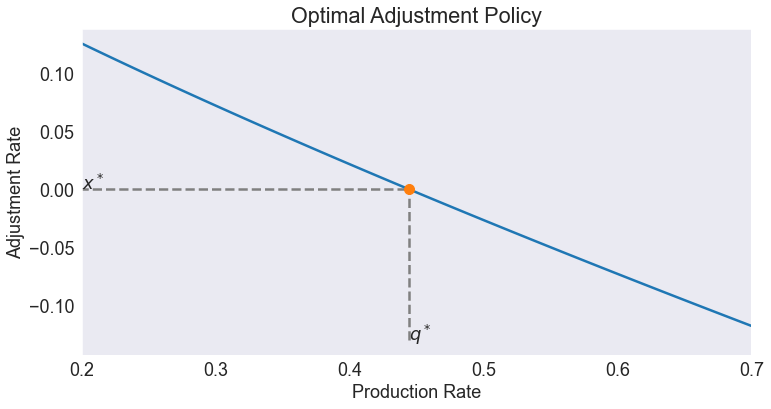

In [6]:
fig, ax = plt.subplots()
data['control'].plot(ax=ax)
ax.set(title='Optimal Adjustment Policy',
       xlabel='Production Rate',
       ylabel='Adjustment Rate',
       xlim=[qmin, qmax])

lb = ax.get_ylim()[0]
ax.hlines(xstar, 0, qstar, colors=['gray'], linestyles=['--'])
ax.vlines(qstar, lb, xstar, colors=['gray'], linestyles=['--'])
ax.annotate('$x^*$', (qmin, xstar))
ax.annotate('$q^*$', (qstar, lb))
ax.plot(qstar, xstar, '.', ms=20);

### Value function

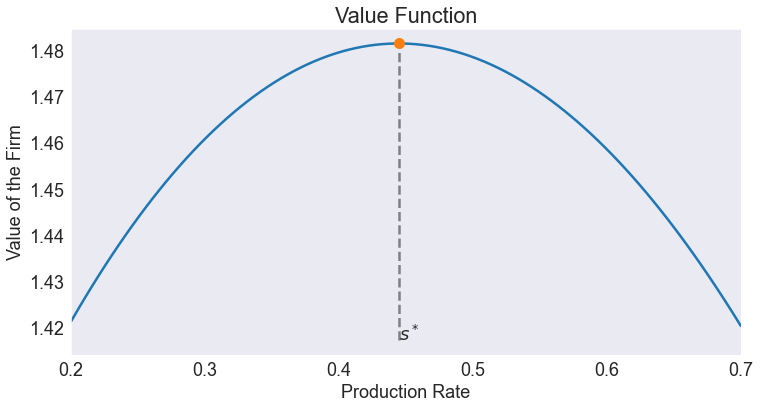

In [7]:
fig, ax = plt.subplots()
data['value'].plot(ax=ax)
ax.set(title='Value Function',
       xlabel='Production Rate',
       ylabel='Value of the Firm',
       xlim=[qmin, qmax])

lb = ax.get_ylim()[0]
ax.vlines(qstar, lb , vstar, colors=['gray'], linestyles=['--'])
ax.annotate('$s^*$', (qstar, lb))
ax.plot(qstar, vstar, '.', ms=20);

### Shadow price

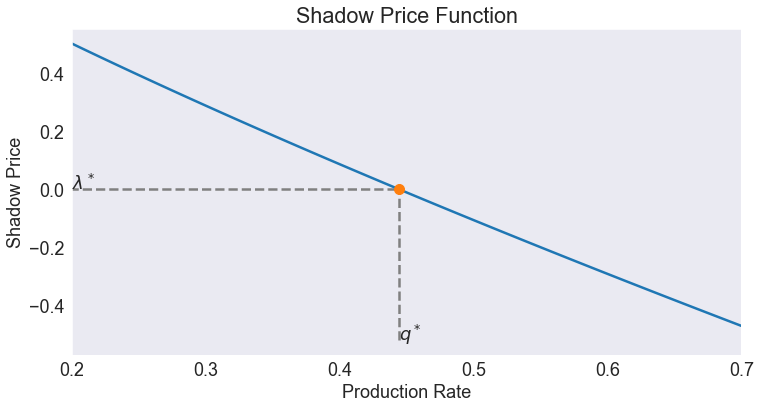

In [8]:
data['shadow'] = model.Value(data.index, 1)

fig, ax = plt.subplots()
data['shadow'].plot(ax=ax)
ax.set(title='Shadow Price Function',
       xlabel='Production Rate',
       ylabel='Shadow Price',
       xlim=[qmin, qmax])

pstar = model.Value(qstar, 1)
lb = ax.get_ylim()[0]
ax.hlines(pstar, 0, qstar, colors=['gray'], linestyles=['--'])
ax.vlines(qstar, lb , pstar, colors=['gray'], linestyles=['--'])
ax.annotate('$\lambda^*$', (qmin, pstar))
ax.annotate('$q^*$', (qstar, lb))
ax.plot(qstar, pstar, '.', ms=20);

### Residual

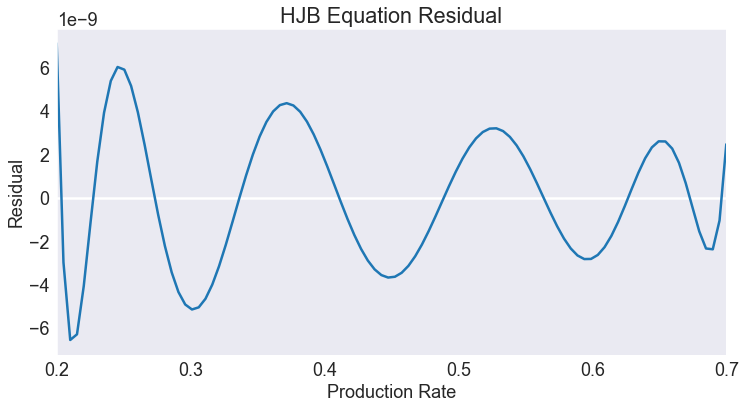

In [9]:
fig, ax = plt.subplots()
ax.axhline(0, c='white')
data['resid'].plot(ax=ax)
ax.set(title='HJB Equation Residual',
       xlabel='Production Rate',
       ylabel='Residual',
       xlim=[qmin, qmax]);

## Simulate the model

### Initial state and time horizon

In [10]:
q0 = 0.2   # initial production
T  = 10    # time horizon

### Simulation and plot

PARAMETER xnames NO LONGER VALID. SET labels= AT OBJECT CREATION


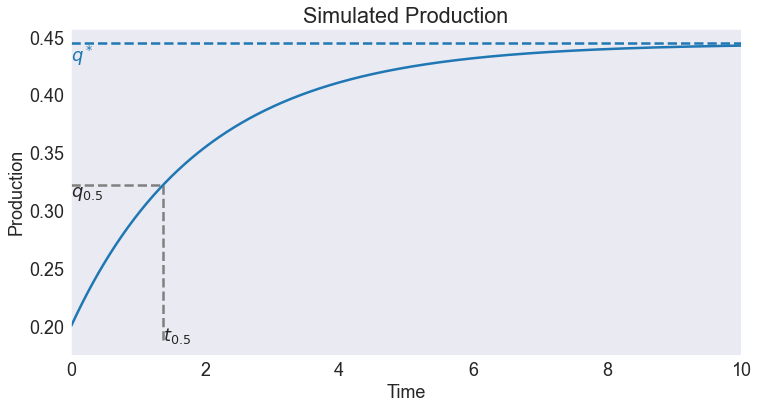

In [11]:
fig, ax = plt.subplots()
simulation = model.simulate([[q0]], T)

# Time to midway adjustment
qhalf = (q0 + qstar)/2
thalf = np.interp(qhalf, simulation['$y_0$'], simulation.index)


simulation['$y_0$'].plot(ax=ax)
ax.set(title='Simulated Production',
       xlabel='Time',
       ylabel='Production',
       xlim=[0, T],
       xticks=np.arange(0,T+1,2))

ax.axhline(qstar, ls='--', c='C0')
ax.annotate('$q^*$', (0, qstar), color='C0', va='top')

lb = ax.get_ylim()[0]
ax.vlines(thalf, lb , qhalf, colors=['gray'], linestyles=['--'])
ax.hlines(qhalf, 0 , thalf, colors=['gray'], linestyles=['--'])

ax.annotate('$t_{0.5}$', (thalf, lb))
ax.annotate('$q_{0.5}$', (0, qhalf),va='top')

ax.legend([]);